## Sagnac Frequency - Phase Jump Detection

...

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"


config['tbeg'] = UTCDateTime("2024-05-25 00:00")
config['tend'] = UTCDateTime("2024-05-25 06:00")

# config['tbeg'] = UTCDateTime("2024-05-31 00:00")
# config['tend'] = UTCDateTime("2024-06-01 00:00")

flim1, flim2 = 447.726, 447.745

config['time_offset'] = 60 # seconds

config['t1'] = config['tbeg']-config['time_offset']
config['t2'] = config['tend']+config['time_offset']

# specify sampling rate of rotation rate data
config['sampling_rate'] = 20 # Hz

# compute expected number of samples
config['Nexpected'] = int((config['t2'] - config['t1']) * config['sampling_rate'])

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_sds_out'] = archive_path+"temp_archive/"

config['path_to_inventory'] =  data_path+"stationxml_ringlaser/dataless/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

### Load backscatter data

In [ ]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Load rotation rate data

In [8]:
romy_inv = read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

In [9]:
st0 = Stream()

st0 += __read_sds(config['path_to_sds'], "BW.ROMY.10.BJZ", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['t1'], config['t2'])

# remove sensitivity
st0 = st0.remove_sensitivity(romy_inv)

print(st0)

# check if merging is required
if len(st0) > 3:
    print(f" -> merging required!")
    st0.merge(fill_value="interpolate")

print(st0)

# remove trend
st0 = st0.detrend("linear")

# check if data has same length
for tr in st0:
    Nreal = len(tr.data)
    if Nreal != config['Nexpected']:
        tr.data = tr.data[:config['Nexpected']]
        # print(f" -> adjust length: {tr.stats.station}.{tr.stats.channel}:  {Nreal} -> {config['Nexpected']}")

# st0 = __rotate_romy_ZUV_ZNE(st0, romy_inv, keep_z=True)

# st0 = st0.trim(config['tbeg'], config['tend'])

st0

3 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-05-24T23:59:00.009799Z - 2024-05-25T06:01:00.009799Z | 20.0 Hz, 434401 samples
BW.ROMY..BJU   | 2024-05-24T23:58:59.989000Z - 2024-05-25T06:00:59.989000Z | 20.0 Hz, 434401 samples
BW.ROMY..BJV   | 2024-05-24T23:59:00.019599Z - 2024-05-25T06:01:00.019599Z | 20.0 Hz, 434401 samples
3 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-05-24T23:59:00.009799Z - 2024-05-25T06:01:00.009799Z | 20.0 Hz, 434401 samples
BW.ROMY..BJU   | 2024-05-24T23:58:59.989000Z - 2024-05-25T06:00:59.989000Z | 20.0 Hz, 434401 samples
BW.ROMY..BJV   | 2024-05-24T23:59:00.019599Z - 2024-05-25T06:01:00.019599Z | 20.0 Hz, 434401 samples


3 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-05-24T23:59:00.009799Z - 2024-05-25T06:00:59.959799Z | 20.0 Hz, 434400 samples
BW.ROMY..BJU   | 2024-05-24T23:58:59.989000Z - 2024-05-25T06:00:59.939000Z | 20.0 Hz, 434400 samples
BW.ROMY..BJV   | 2024-05-24T23:59:00.019599Z - 2024-05-25T06:00:59.969599Z | 20.0 Hz, 434400 samples

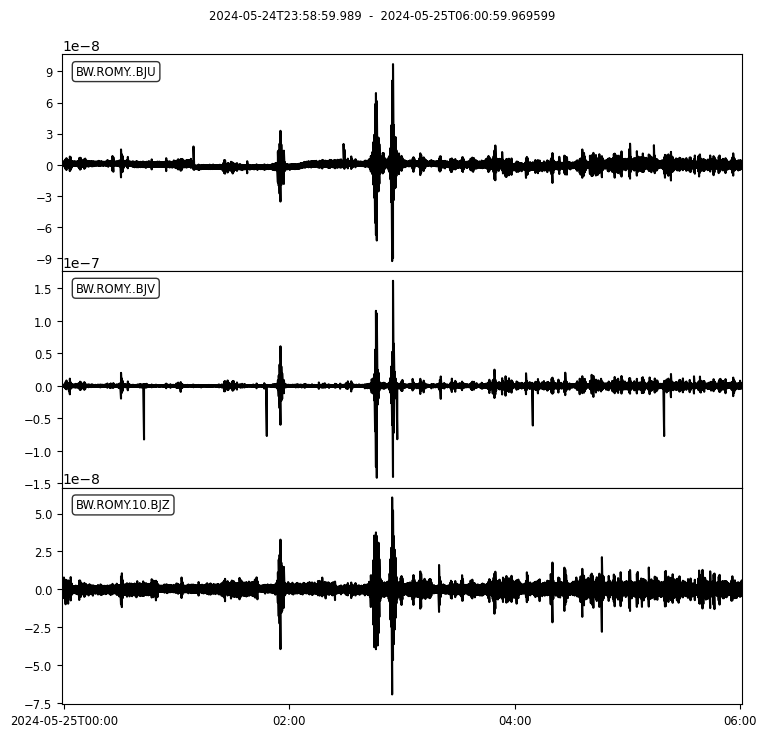

In [10]:
st0.plot(equal_scale=False);

In [ ]:
def get_phase_jumps(arr, times, LT, ST, amp_threshold, plot=True):

    import numpy as np
    from scipy.signal import hilbert
    from functions.smoothing import __smooth

    def sta_lta_detect(_data, threshold_upper, threshold_lower=None):

        N = len(_data)

        detection = np.ones(N)
        ratio = np.zeros(N)

        triggered = False
        for n in range(N):

            if n < LT:
                continue

            # compupte LTA, STA and ratio
            LTA = np.nanmean(abs(_data[n-int(LT):n]))
            STA = np.nanmean(abs(_data[n-int(ST):n]))
            ratio[n] = abs(STA-LTA)

            if triggered and ratio[n] > threshold_lower and threshold_lower is not None:
                detection[n] = 0
                continue
            else:
                triggered = False

            if ratio[n] > threshold_upper and threshold_lower is not None:
                detection[n] = np.nan
                detection[n-1] = np.nan
                triggered = True

        # detect events based on threshold
        for n, a in enumerate(ratio):
            if a > threshold_upper:
                detection[n] = np.nan
                detection[n-1] = np.nan

        return detection, ratio


    amp_threshold_lower = 0.5

    # dpha = __smooth(dpha, 10)

    # 1st derivative of amplitude
    damp = np.gradient(arr)

    # 2nd derivative
    # damp = np.gradient(damp)

    # absolute values
    damp = abs(damp)

    detect, amp_ratio = sta_lta_detect(damp, amp_threshold)

    if plot:

        import matplotlib.pyplot as plt

        Nrow, Ncol = 2, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ax[0].plot(times, arr)
        ax[0].plot(times, arr*np.array(detect))

        ax[1].plot(times, amp_ratio, "k")
        ax[1].axhline(amp_threshold, color="darkred", alpha=0.5, ls="--")
        ax[1].set_ylim(0, 3*amp_threshold)

        for _k in range(Nrow):
            ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

        for _n, d in enumerate(detect):
            if np.isnan(d):
                ax[0].axvline(times[_n], 0, np.nanmax(arr)*2, color="grey", alpha=0.2, zorder=1)
                ax[1].axvline(times[_n], 0, 10, color="grey", alpha=0.2, zorder=1)

        plt.show();

    # change detections to one and everything else to zero
    detect2 = abs(np.nan_to_num(detect, 0) - 1)

    return np.array(amp_ratio), np.array(detect2)

In [ ]:
# x1 = 1000
# x2 = x1+6000

# data0 = np.array(bs.fj_fs[x1:x2])
# time0 = np.array(bs.time_sec[x1:x2])

data0 = np.array(bs.fj_fs)
time0 = np.array(bs.time_sec)

ratio, detect = get_phase_jumps(data0, time0, 10, 3, amp_threshold=0.00008)

In [ ]:
# n = st0.select(component="U")[0].data
# ntime = st0.select(component="U")[0].times()

# # ratio, detect = get_phase_jumps(n, ntime, 10, 3, amp_threshold=0.0001)

In [ ]:
mask1 = np.where(detect == 1, bs.time1, np.nan)
mask2 = np.where(detect == 1, bs.time2, np.nan)

mask_df = DataFrame()
mask_df['mask1'] = mask1
mask_df['mask2'] = mask2

mask_df = mask_df.dropna()

mask1 = np.array(mask_df.mask1)
mask2 = np.array(mask_df.mask2)

In [ ]:
def __get_trace(seed):

    from obspy import Trace
    from numpy import zeros

    net, sta, loc, cha = seed.split('.')

    trr = Trace()
    trr.stats.starttime = config['t1']
    trr.data = zeros(config['Nexpected'])
    trr.stats.network = net
    trr.stats.station = sta
    trr.stats.location = loc
    trr.stats.channel = cha
    trr.stats.sampling_rate = config['sampling_rate']

    return trr

In [ ]:
def __mlti_intervals_to_zero(dat, times, mlti_t1, mlti_t2, t_offset_sec=120):

    from numpy import nan, where, full, array

    dat = array(dat)

    mask = full((len(times)), 0, dtype=int)

    idx = 0
    for nn, tt in enumerate(times):

        if idx >= len(mlti_t1):
            continue
        else:
            t1, t2 = (mlti_t1[idx]-t_offset_sec), (mlti_t2[idx]+t_offset_sec)

        if tt >= t1:
            mask[nn] = 1
        if tt > t2:
            idx += 1

    dat = where(mask == 1, 1, dat)

    return dat

In [ ]:
import obspy as obs

tr_maskV = __get_trace("BW.ROMY.30.MLT")

tr_maskV.data = __mlti_intervals_to_zero(tr_maskV.data,
                                         tr_maskV.times(reftime=config['t1'], type="utcdatetime"),
                                         mask1,
                                         mask2,
                                         t_offset_sec=60,
                                         )

In [ ]:
tr_maskV.plot();

In [ ]:
import numpy.ma as ma

st0.select(component="V")[0].data = ma.masked_array(st0.select(component="V")[0].data,
                                                    mask=tr_maskV.data,
                                                    fill_value=np.nan
                                                   )

st0.plot(equal_scale=False)

In [ ]:
x1 = int(5*3600*20)
x2 = x1+int(2*3600*20)

V = st0.select(component="V")[0].data[x1:x2]
Vtime = st0.select(component="V")[0].times()[x1:x2]

V = st0.select(component="V")[0].data
Vtime = st0.select(component="V")[0].times()

plt.plot(V)

# test, tt, yy, ii = __get_phase_jumps(V, Vtime, fraction_of_pi=2, plot=True)


In [107]:
import numpy as np

def masking(img, n=3, method='mean', stats=[None, None]):
    '''
    Search for outlayer pixels with a value lower/larger
    than the mean/median/other ± n × std
    '''
    if method.lower() == 'average':
        avg, std = stats[0], stats[1]
    elif method == 'mean':
        avg, std = np.nanmean(img), np.nanstd(img)
    elif method == 'median':
        avg, std = np.nanmedian(img), np.nanstd(img)
    return (img < (avg - n * std)) | (img > (avg + n * std))

def box(A, i, j, size=1, nan=False):
    '''
    Extract the box (subarray) around (i,j) value inside
    a box of size `size` and replace the centrale
    value by NaN if necessary [option].
    '''
    if not isinstance(A, (list, np.ndarray)):
        raise TypeError(
            'The input must be an array. {} provided'.format(type(A)))

    ny, nx = A.shape
    if i < 0:
        raise ValueError('Line index `i` must be ≥ 0')
    if j < 0:
        raise ValueError('Column index `j` must be ≥ 0')
    if i >= nx:
        raise ValueError('Line index `i` must be < {}'.format(nx))
    if j >= ny:
        raise ValueError('Column index `j` must be < {}'.format(ny))

    if not isinstance(size, int):
        raise TypeError('Size must be an int')
    if size < 1:
        raise ValueError('The box size must be ≥ 1')

    if nan:
        # The change of type is required to store a NaN
        A = np.array(A, dtype=np.double)
        A[j, i] = np.nan

    l = i - size if i - size > 0 else 0
    r = i + size if i + size < nx else nx
    t = j - size if j - size > 0 else 0
    b = j + size if j + size < ny else ny

    return A[t:b+1, l:r+1]

def mean(A):
    return np.nanmean(A), np.nanstd(A)

def median(A):
    return np.nanmedian(A), np.nanstd(A)

def spikes(img, method='mean', size=2, n=3, thres=None):
    '''
    Search spikes in the image using a moving box
    of size `size` using `method` method with ± n × std
    '''
    if method.lower() == 'mean':
        mask = mean
    elif method.lower() == 'median':
        mask = median
    elif method.lower() == 'average':
        mask = None
        m, s = np.median(img), 1e-8
    else:
        raise ValueError("The masking method must be '[mean|median]")

    # s = np.nanpercentile(abs(img), 98)

    ny, nx = img.shape
    _spikes = np.zeros((ny, nx))
    for i in range(nx):
        for j in range(ny):
            m, s = mask(box(img, i, j, size, nan=True))

            # set threshold
            if thres is not None:
                if n * s < thres:
                    s = thres

            if img[j, i] < m - n * s or img[j, i] > m + n * s:
                _spikes[j, i] = 1

    return _spikes == 1

def fill(img, mask, method='mean', size=1):
    '''
    Fill the masked pixels with the mean value of
    surrounding neighboors inside a box of size `size`
    '''
    if img.shape != mask.shape:
        raise ValueError('Image and outlayers mask must have the same dimentsion: {} vs. {}'.format(
            img.shape, mask.shape
        ))

    if method.lower() == 'mean':
        f = np.nanmean
    elif method.lower() == 'median':
        f = np.nanmedian
    elif method.lower() == 'nan':
        f = np.nanmedian
    else:
        raise ValueError("The filling method must be '[mean|median]")

    A = np.copy(img)
    ny, nx = A.shape
    x, y = np.meshgrid(range(nx), range(ny))

    for x, y in zip(x[mask], y[mask]):
        A[y, x] = f(box(A, x, y, size=size, nan=True))
        # if method.lower() == 'nan':
        #     A *= np.nan
        #     print(A, type(A))
    return A


def clean(img, mask='mean', size=2, n=3, fill_method='median', fill_size=1, thres=None):
    '''
    Clean image from spikes with the `fill_method` method with surrounding
    neighboors inside a box of size `fill_size`.
    '''

    # use absolute of image (seismic data)
    aimg = abs(img)

    return fill(img, spikes(aimg, mask, size, n, thres), fill_method, fill_size), spikes(aimg, mask, size, n, thres)

def signal_to_image(arr):
    '''
    1d signal to square image
    '''
    # estimate size of square image
    N = int(np.ceil(np.sqrt(len(arr))))

    # compute difference required for square image
    Npad = N**2 - len(arr)

    # pad additional values with last value of signal
    _pad = np.append(arr, np.ones(Npad)*arr[-1])

    # reshape to square image
    img = _pad.reshape(N, N)

    return img, Npad

def image_to_signal(img, pad=0):
    '''
    reshape image to 1d signal
    '''
    return img.reshape(1, img.size)[0][:-pad]


def get_mask(spikes):
    '''
    modify 1d spikes to mask
    '''
    mask = np.where(spikes > 0, -1, spikes)
    mask = np.where(mask == 0, 1, mask)
    mask = np.where(mask < 0, np.nan, mask)
    return mask

def smooth(y, npts):
    '''
    moving average of 1d signal for n samples
    '''
    win = np.hanning(npts)
    y_smooth = np.convolve(y, win/np.sum(win), mode='same')
    y_smooth[:npts//2] = np.nan
    y_smooth[-npts//2:] = np.nan
    return y_smooth


In [137]:
V = st0.copy().select(component="V").trim(config['tbeg'], config['tend'], nearest_sample=False)[0].data

In [138]:
plt.plot(V)

In [110]:
# # get image for signal
# Vimg, Npad = signal_to_image(V)

# # get absolute image
# aVimg = abs(Vimg)

# # find spikes
# Vimg_clean, Vimg_spikes = clean(Vimg, mask='median', size=5, n=5, fill_method='median', fill_size=2, thres=1e-8)

# # turn image to signal
# V_filt = image_to_signal(Vimg_clean, pad=Npad)
# spikes = image_to_signal(Vimg_spikes, pad=Npad)

# # create mask from spikes
# mask = get_mask(spikes)

# # smooth mask
# mask_smooth = smooth(mask, 10)

# # apply mask
# V_masked = V * mask_smooth


In [111]:
from functions.get_time_intervals import __get_time_intervals

In [112]:
tinterval = 3600
ninterval = 20*tinterval

times = __get_time_intervals(config['tbeg'], config['tend'], tinterval, 0)

In [113]:
from tqdm.notebook import tqdm

_spikes = np.zeros(int((config['tend'] - config['tbeg'])*20))
_cleans = np.zeros(int((config['tend'] - config['tbeg'])*20))

n2 = 0
for _k, (t1, t2) in enumerate(tqdm(times)):

    _V = st0.select(component="V").copy().trim(t1, t2, nearest_sample=False)[0].data

    # get amount of samples of subdata
    NV = len(_V)

    if _k == 0:
        n1, n2 = 0, NV

    # get image for signal
    Vimg, Npad = signal_to_image(_V)

    # get absolute image
    aVimg = abs(Vimg)

    # find spikes
    Vimg_clean, Vimg_spikes = clean(Vimg, mask='mean', size=15, n=10, fill_method='median', fill_size=2, thres=1e-8)

    # turn image to signal
    _cleans[n1:n2] = image_to_signal(Vimg_clean, pad=Npad)
    _spikes[n1:n2] = image_to_signal(Vimg_spikes, pad=Npad)

    n1, n2 = n1+NV, n2+NV

V_filt = _cleans
spikes = _spikes

  0%|          | 0/6 [00:00<?, ?it/s]

In [114]:

# create mask from spikes
mask = get_mask(spikes)

# smooth mask
mask_smooth = smooth(mask, 10)

# apply mask
V_masked = V * mask_smooth


In [67]:
%matplotlib tk

In [68]:
plt.plot(V)
plt.plot(V_masked)

In [115]:
Vimg, _ = signal_to_image(V)
aVimg = abs(Vimg)

Vimg_spikes, _ = signal_to_image(spikes)


def __makeplot():
    import matplotlib.pyplot as plt

    from matplotlib.gridspec import GridSpec

    fig = plt.figure(layout="constrained", figsize=(15, 10))

    gs = GridSpec(3, 3, figure=fig)

    ax1 = fig.add_subplot(gs[:1, :])
    ax2 = fig.add_subplot(gs[1, 0:1])
    ax3 = fig.add_subplot(gs[1, 1:2])
    ax4 = fig.add_subplot(gs[1, 2:3])

    # fig.suptitle("GridSpec")

    cmap1 = plt.get_cmap('viridis')

    vmin, vmax = 0, 1e-8
    #max(aVimg.reshape(aVimg.shape[0]*aVimg.shape[1]))

    ax1.plot(V)
    ax1.plot(V_masked)
    # for sp in spikes:
    #     ax1.axvline(sp, color="grey", zorder=1, alpha=0.6)

    ax2.imshow(aVimg, cmap=cmap1, vmin=vmin, vmax=vmax)
    ax3.imshow(Vimg_spikes, cmap=plt.get_cmap('gray'))
    ax4.imshow(aVimg*Vimg_spikes, cmap=cmap1, vmin=vmin, vmax=vmax)

    # ax0.set_title('Original image')
    # ax1.set_title('Median mask')
    # ax2.set_title('Median image')

    plt.show();

__makeplot()

invalid command name "140618524786432delayed_destroy"
    while executing
"140618524786432delayed_destroy"
    ("after" script)
invalid command name "140618529335360delayed_destroy"
    while executing
"140618529335360delayed_destroy"
    ("after" script)


In [172]:
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import plot_trigger

tr = st0.copy().select(component="V")[0]

tr = tr.detrend("demean")

t_lta = 50 # second
t_sta = 1 # second

threshol_upper = 40 # empirical

df = tr.stats.sampling_rate

cft = classic_sta_lta(tr.data, int(t_sta * df), int(t_lta * df))


plot_trigger(tr, cft, threshol_upper, 1, show=False)

mask = np.where(cft < threshol_upper, 0, cft)
mask = np.where(mask > threshol_upper, 1, mask)

mask_smooth = smooth(mask, 20)


In [173]:
plt.figure()
plt.plot(tr.data)
plt.plot(tr.data*abs(mask_smooth-1))

In [125]:
def __get_phase_jumps(arr, time, fraction_of_pi=6, plot=True):

    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.signal import hilbert


    def smooth(y, npts):
        '''
        moving average of 1d signal for n samples
        '''
        win = np.hanning(npts)
        y_smooth = np.convolve(y, win/np.sum(win), mode='same')
        y_smooth[:npts//2] = np.nan
        y_smooth[-npts//2:] = np.nan
        return y_smooth

    data = arr.copy()

    # detect phase changes
    dpha_y = [_x if abs(_x) > threshold and abs(_x) < 3.14 else np.nan for _x in dpha]

    # detect phase indices
    dpha_idx = [list(dpha).index(_x) for _x in dpha if abs(_x) > threshold and abs(_x) < 3.14]

    # apply filter
    out = [np.nan if _i in dpha_idx else arr[_i] for _i in range(len(arr))]

    # checkup plot
    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(15, 8))

        ax[0].plot(time, dpha)
        ax[0].scatter(time, dpha_y, color="tab:orange", s=10, zorder=2)
        ax[0].axhline(threshold, color="red", ls="--", alpha=0.5)
        ax[0].axhline(-threshold, color="red", ls="--", alpha=0.5)

        ax[1].plot(time, data)
        for line in time[dpha_idx]:
            ax[1].axvline(line, -1000, 1000, zorder=0, alpha=0.3, color="tab:orange")

        plt.show();

    return np.array(out), time[dpha_idx], np.array(dpha_y)[dpha_idx], np.array(dpha_idx)

In [132]:
x1 = int(0*3600*20)
x2 = x1+int(6*3600*20)

V = st0.select(component="V")[0].data[x1:x2]
Vtime = st0.select(component="V")[0].times()[x1:x2]

get_phase_jumps(V, Vtime, 50, 10, 1e-8, plot=True)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.61044030e-10, 1.70702887e-10, 1.09903627e-10]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [ ]:
# # Median filtering
# from despike.median import mask, median

# median_mask = mask(aVimg, 20)
# # median_img = median(Vimg, n=15, size=5)


# Vimg_new = aVimg - aVimg*median_mask

# f, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(21, 7))

# cmap1 = plt.get_cmap('viridis')

# ax0.imshow(aVimg, cmap=cmap1, vmin=0)
# ax1.imshow(median_mask, cmap=plt.get_cmap('gray'))
# ax2.imshow(Vimg_new, cmap=cmap1, vmin=0)
# ax0.set_title('Original image')
# ax1.set_title('Median mask')
# ax2.set_title('Median image')
# plt.show()

In [ ]:
x1 = int(5*3600*20)
x2 = x1+int(1*3600*20)

V = st0.select(component="V")[0].data[x1:x2]
Vtime = st0.select(component="V")[0].times()[x1:x2]

plt.plot(V)


### Compute Backscatter (again)

In [ ]:
from functions.backscatter_correction import __backscatter_correction

In [ ]:
# unwrap phases as one time series
# bs['fj_ph'] = np.unwrap(bs.fj_ph)
# bs['f1_ph'] = np.unwrap(bs.f1_ph)
# bs['f2_ph'] = np.unwrap(bs.f2_ph)

# use complete unwrapped phases
bs['fj_ph'] = np.unwrap(bs.fj_phw)
bs['f1_ph'] = np.unwrap(bs.f1_phw)
bs['f2_ph'] = np.unwrap(bs.f2_phw)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=1.033)


### Find phase jumps

In [ ]:
bs['fj_fs'], tt, yy, ii = __get_phase_jumps(bs.fj_fs, bs.time_sec, fraction_of_pi=6, plot=True)

In [ ]:
_, tt1, yy1, ii1 = __get_phase_jumps(bs.fj_fs, bs.time_sec, fraction_of_pi=50, plot=False)

_, tt2, yy2, ii2 = __get_phase_jumps(bs.fj_bs, bs.time_sec, fraction_of_pi=50, plot=False)


In [118]:
def get_phase_jumps(arr, times, LT, ST, amp_threshold, plot=True):

    import numpy as np
    from scipy.signal import hilbert
    from functions.smoothing import __smooth

    def sta_lta_detect(_data, threshold_upper, threshold_lower=None):

        N = len(_data)

        detection = np.ones(N)
        ratio = np.zeros(N)

        triggered = False
        for n in range(N):

            if n < LT:
                continue

            # compupte LTA, STA and ratio
            LTA = np.nanmean(abs(_data[n-int(LT):n]))
            STA = np.nanmean(abs(_data[n-int(ST):n]))
            ratio[n] = abs(STA-LTA)

            if triggered and ratio[n] > threshold_lower and threshold_lower is not None:
                detection[n] = 0
                continue
            else:
                triggered = False

            if ratio[n] > threshold_upper and threshold_lower is not None:
                detection[n] = np.nan
                detection[n-1] = np.nan
                triggered = True

        # detect events based on threshold
        for n, a in enumerate(ratio):
            if a > threshold_upper:
                detection[n] = np.nan
                detection[n-1] = np.nan

        return detection, ratio


    amp_threshold_lower = 0.5

    # dpha = __smooth(dpha, 10)

    # 1st derivative of amplitude
    damp = np.gradient(arr)

    # 2nd derivative
    # damp = np.gradient(damp)

    # absolute values
    damp = abs(damp)

    detect, amp_ratio = sta_lta_detect(damp, amp_threshold)

    if plot:

        import matplotlib.pyplot as plt

        Nrow, Ncol = 2, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ax[0].plot(times, arr)
        ax[0].plot(times, arr*np.array(detect))

        ax[1].plot(times, amp_ratio, "k")
        ax[1].axhline(amp_threshold, color="darkred", alpha=0.5, ls="--")
        ax[1].set_ylim(0, 3*amp_threshold)

        for _k in range(Nrow):
            ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

        for _n, d in enumerate(detect):
            if np.isnan(d):
                ax[0].axvline(times[_n], 0, np.nanmax(arr)*2, color="grey", alpha=0.2, zorder=1)
                ax[1].axvline(times[_n], 0, 10, color="grey", alpha=0.2, zorder=1)

        plt.show();

    # change detections to one and everything else to zero
    detect2 = abs(np.nan_to_num(detect, 0) - 1)

    return np.array(amp_ratio), np.array(detect2)

In [117]:
x1 = 1000
x2 = x1+6000

# data0 = np.array(bs.fj_fs[x1:x2])
# time0 = np.array(bs.time_sec[x1:x2])

data0 = np.array(bs.fj_fs)
time0 = np.array(bs.time_sec)

ratio, detect = get_phase_jumps(data0, time0, 10, 3, amp_threshold=0.00025)

NameError: name 'bs' is not defined

In [ ]:
print(len(bs.fj_fs), len(detect))


mask = np.where(detect==1, 1, 0)

time_mask = time0 * detect

time_inter = time_mask[time_mask != 0]

inter = np.diff(time_inter)
inter[0] = inter[1]

plt.figure()
plt.plot(np.cumsum(detect))

NN = 3600
plt.figure()
plt.hist(inter, bins=int(NN/60), range=(0, NN), log=True, rwidth=0.7)
plt.ylim(bottom=0.5)

In [ ]:
data = np.array(bs.fj_fs)

for _i in range(len(data)):

    if detect[_i] == 1:
        left = np.nanmean(data[_i-8:_i-3])
        right = np.nanmean(data[_i+3:_i+8])

        diff = left - right

        data[_i-3:_i] = left

        data[_i:] += diff


# plt.plot(bs.fj_fs[:-40000])
# plt.plot(data[:-40000])

plt.plot(bs.fj_fs)
plt.plot(data)

# plt.ylim(flim1, flim2)